In [1]:
import os
import json
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from huggingface_hub import notebook_login
from transformers import StoppingCriteria
from typing import Any, List

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Loading Model

In [2]:
if "model" in locals():
    del model
    torch.cuda.empty_cache()
if "tokenizer" in locals():
    del tokenizer

path = "daryl149/llama-2-70b-chat-hf"
model = AutoModelForCausalLM.from_pretrained(
                path,
                device_map="auto",
                load_in_4bit=True,
                torch_dtype=torch.float16,
            )
tokenizer = AutoTokenizer.from_pretrained(path, padding_side="left")

tokenizer.pad_token = tokenizer.eos_token

config.json:   0%|          | 0.00/577 [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/66.7k [00:00<?, ?B/s]

pytorch_model-00001-of-00015.bin:   0%|          | 0.00/9.85G [00:00<?, ?B/s]

pytorch_model-00002-of-00015.bin:   0%|          | 0.00/9.80G [00:00<?, ?B/s]

pytorch_model-00003-of-00015.bin:   0%|          | 0.00/9.97G [00:00<?, ?B/s]

pytorch_model-00004-of-00015.bin:   0%|          | 0.00/9.80G [00:00<?, ?B/s]

pytorch_model-00005-of-00015.bin:   0%|          | 0.00/9.80G [00:00<?, ?B/s]

pytorch_model-00006-of-00015.bin:   0%|          | 0.00/9.80G [00:00<?, ?B/s]

pytorch_model-00007-of-00015.bin:   0%|          | 0.00/9.97G [00:00<?, ?B/s]

pytorch_model-00008-of-00015.bin:   0%|          | 0.00/9.80G [00:00<?, ?B/s]

pytorch_model-00009-of-00015.bin:   0%|          | 0.00/9.80G [00:00<?, ?B/s]

pytorch_model-00010-of-00015.bin:   0%|          | 0.00/9.80G [00:00<?, ?B/s]

pytorch_model-00011-of-00015.bin:   0%|          | 0.00/9.97G [00:00<?, ?B/s]

pytorch_model-00012-of-00015.bin:   0%|          | 0.00/9.80G [00:00<?, ?B/s]

pytorch_model-00013-of-00015.bin:   0%|          | 0.00/9.80G [00:00<?, ?B/s]

pytorch_model-00014-of-00015.bin:   0%|          | 0.00/9.50G [00:00<?, ?B/s]

pytorch_model-00015-of-00015.bin:   0%|          | 0.00/524M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/15 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/745 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/411 [00:00<?, ?B/s]

# Loading Data

In [4]:
with open("data/unexpected_contents.jsonl") as f:
    unexpected_contents = [json.loads(line) for line in f]

with open("data/unexpected_transfer.jsonl") as f:
    unexpected_transfer = [json.loads(line) for line in f]

In [5]:
tasks = []
for data in unexpected_contents + unexpected_transfer:
    for i in range(3):
        inp = {
            "input": data['prompts'][i],
            "target": data[f'target_{i+1}']
        }
        tasks.append(inp)

In [6]:
# Create a dataset from tasks list
dataset = Dataset.from_list(tasks).with_format("torch")

# Create a collate function to tokenize and pad the data
def collate_fn(examples):
    inputs = tokenizer(
        [ex["input"] for ex in examples],
        return_tensors="pt",
        padding=True,
        truncation=True,
    )
    if (
        model.config.architectures[0] == "GPT2LMHeadModel"
        or model.config.architectures[0] == "GPTNeoXForCausalLM"
        or model.config.architectures[0] == "GPTJForCausalLM"
    ):
        inputs["target"] = [tokenizer.decode(tokenizer.encode(" " + ex["target"])[0]) for ex in examples]
    elif (
        model.config.architectures[0] == "LlamaForCausalLM"
        or model.config.architectures[0] == "LlaMAForCausalLM"
        or model.config.architectures[0] == "GemmaForCausalLM"
    ):
        inputs["target"] = [
            tokenizer.decode(tokenizer.encode(ex["target"])[1]) for ex in examples
        ]
    elif model.config.architectures[0] == "MistralForCausalLM":
        inputs["target"] = [tokenizer.decode(tokenizer.encode(" " + ex["target"])[2]) for ex in examples]
    return inputs

# Create a DataLoader
dataloader = DataLoader(
    dataset, collate_fn=collate_fn, batch_size=1, shuffle=False
)

# Model Performance

In [7]:
correct, total = 0, 0
with torch.no_grad():
    for inp in tqdm(dataloader, total=len(dataloader)):
        inp["input_ids"] = inp["input_ids"].to(device)
        inp["attention_mask"] = inp["attention_mask"].to(device)

        outputs = model(inp["input_ids"])
        logits = outputs.logits
        predicted_ids = torch.argmax(logits[:, -1], dim=-1)
        predicted_token = tokenizer.decode(predicted_ids)

        if predicted_token.strip() == inp["target"][0].strip():
            correct += 1
        else:
            print(f"Predicted: {predicted_token.strip()}; Target: {inp['target'][0].strip()}")
        total += 1

print(f"Accuracy: {correct/total:.2f}")

# Visualizing Model Performance

In [3]:
with open("results.json", "r") as f:
    results = json.load(f)

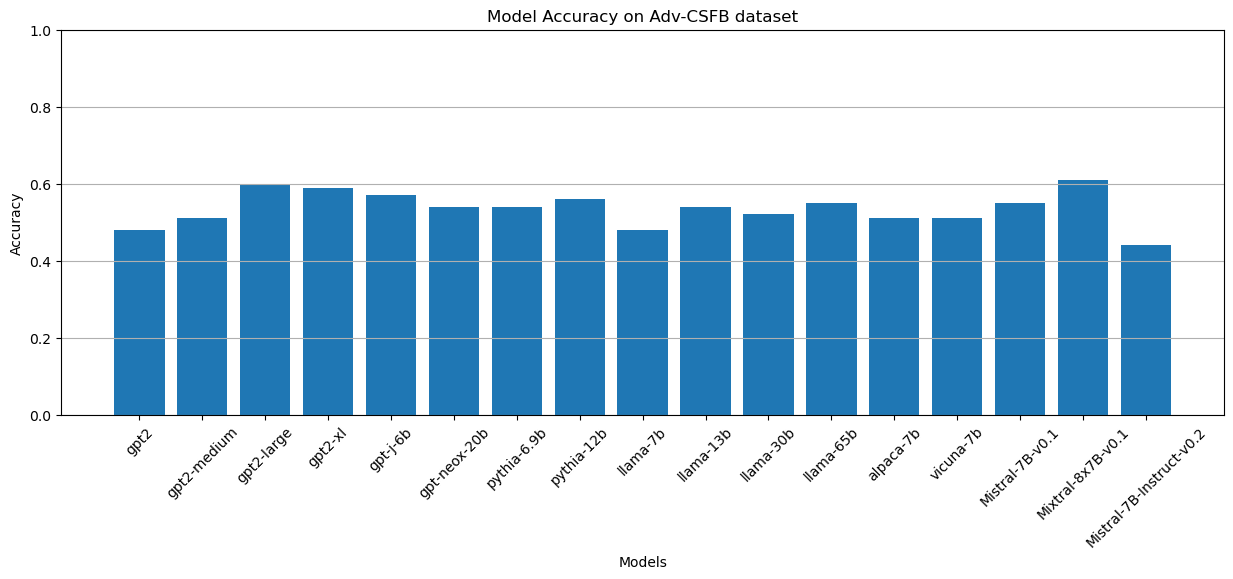

In [5]:
# plot figure size
plt.figure(figsize=(15, 5))
plt.bar(results.keys(), results.values())
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Model Accuracy on Adv-CSFB dataset")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.show()

# Agent Conversation

In [130]:
player_names = {
    "1": "Alice",
    "2": "Bob",
    "3": "Charlie"
}

In [184]:
game_description = f"""WEREWOLF GAME OVERVIEW:
There are you types of players: 1) Werewolves and 2) Villagers (all except werewolves). All players discuss and vote to identify werewolves. In the simplied version, there are three types of cards: 1) Werewolve, 2) Villager, and 3) Troublemaker. 

ROLES:
Villager:
 - Goal: Survive and identify the Werewolf.
 - Actions: Discuss and vote on who the Werewolf might be during the day phase.
Werewolf:
 - Goal: Eliminate Villagers without getting caught.
 - Actions: Discuss and vote along with Villagers during the day.
Troublemaker:
 - Goal: Survive and create confusion to help identify the Werewolf.
 - Actions: At night, choose two players to swap roles without revealing their identities.

GAME PHASES:
Action Phase:
 - All players close their eyes.
 - Troublemaker secretly chooses two players to swap their cards (i.e. roles).
Discussion Phase:
 - Players discuss, deceive, and debate based on shared available information to identify the Werewolf.
 - Each player get only three chances to speak with other players.

WINNING CRITERIA:
 - Villager and Troublemaker win if they correctly identify and eliminate the Werewolf.
 - Werewolf wins if they eliminate a villager or troublemaker to take control.
"""

In [185]:
player_1_role = f"""You are {player_names['1']}. You are playing Werewolf card game with your friends {player_names['2']} and {player_names['3']}. Initially, you've been given the role of Werewolf. First, understand the goals and actions of each player, then speak accordingly to increase your chances of winning."""
player_2_role = f"""You are {player_names['2']}. You are playing Werewolf card game with your friends {player_names['1']} and {player_names['3']}. Initially, you've been given the role of Villager. First, understand the goals and actions of each player, then speak accordingly to increase your chances of winning."""
player_3_role = f"""You are {player_names['3']}. You are playing Werewolf card game with your friends {player_names['1']} and {player_names['2']}. Initially, you've been given the role of Troublemaker. During the night phase, you swapped {player_names['1']} and {player_names['2']}'s cards. Share this information during the Discussion Phase to identify Werewolf. First, understand the goals and actions of each player, then speak accordingly to increase your chances of winning."""

In [186]:
class NewLineStoppingCriteria(StoppingCriteria):
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
        self.newline_token_id = self.tokenizer.encode("\n")[-1]
        self.txt_generated = False

    def __call__(self, input_ids: Any, scores: Any) -> Any:
        """
        Checks if the current generated token is a new line character.
        Returns a tensor of booleans with the same shape as scores,
        indicating whether generation should stop for each sequence.
        """
        latest_token_ids = input_ids[:, -1]
        if latest_token_ids == self.newline_token_id and self.txt_generated:
            self.txt_generated = False
            return True
        else:
            if latest_token_ids != self.newline_token_id:
                self.txt_generated = True
            return False

In [187]:
if os.path.exists("conversation.txt"):
    os.remove("conversation.txt")

stopping_criteria = NewLineStoppingCriteria(tokenizer)

with torch.no_grad():
    for round_idx in tqdm(range(5), total=5):
        for player_idx in range(3):

            if player_idx == 0:
                prompt = f"{game_description}\n\n{player_1_role}\n\n"
            elif player_idx == 1:
                prompt = f"{game_description}\n\n{player_2_role}\n\n"
            else:
                prompt = f"{game_description}\n\n{player_3_role}\n\n"

            conversation = ""
            if os.path.exists("conversation.txt"):
                with open("conversation.txt", "r") as f:
                    conversation = f.read()

            prompt += f"DAY PHASE:\n{conversation}\n{player_names[str(player_idx+1)]} talks: "
            # print(f"INPUT: {prompt}")

            inputs = tokenizer(prompt, return_tensors="pt").to(device)
            outputs = model.generate(
                **inputs,
                max_new_tokens=100,
                num_return_sequences=1,
                temperature=0.00,
                do_sample=False,
                stopping_criteria=[stopping_criteria],
                early_stopping=True,
            )
            response = tokenizer.decode(outputs[0], skip_special_tokens=True)
            print(f"{player_names[str(player_idx+1)]} talks: {response[len(prompt) :].strip()}")
#             print("--------------------------------------------------------------")

            with open("conversation.txt", "a") as f:
                f.write(f"{player_names[str(player_idx+1)]} talks: {response[len(prompt) :]}\n")


  0%|          | 0/5 [00:00<?, ?it/s]

Alice talks: "Hey guys, I think Bob might be the Werewolf. He's been acting strange and avoiding eye contact. Let's lynch him!"
Bob talks: "Guys, I'm not the Werewolf. I'm just nervous because I don't want to be lynched. Let's not jump to conclusions."



 20%|██        | 1/5 [00:35<02:21, 35.35s/it]

Charlie talks: "Guys, I have information that might help us. During the night phase, I swapped Alice and Bob's cards. So, Bob is now a Villager, and Alice is the Werewolf. Let's lynch Alice!"
Alice talks: "What?! That's not true! Charlie is trying to frame me. I'm still a Villager, and Bob is the Werewolf. Don't believe him!"
Bob talks: "Guys, I think we should trust Charlie. He's been acting suspiciously, and now he's trying to frame Alice. Let's lynch Charlie!"



 40%|████      | 2/5 [01:15<01:54, 38.15s/it]

Charlie talks: "Guys, I'm just trying to help. I swear, I'm not the Werewolf. But, if you don't believe me, let's have a vote. Who thinks Alice is the Werewolf?"
Alice talks: "Wait, let's not vote yet. I have an idea. Let's ask Charlie questions about his actions during the night phase. Maybe we can catch him in a lie and expose him as the Werewolf."
Bob talks: "Good idea, Alice. Charlie, can you explain why you swapped our cards?"



 60%|██████    | 3/5 [01:55<01:17, 38.79s/it]

Charlie talks: "Well, I swapped your cards because I wanted to create confusion and help identify the Werewolf. I didn't want to be too obvious and get caught by the Werewolf."
Alice talks: "Hmm, that makes sense. But, why did you choose to swap our cards specifically?"
Bob talks: "Yeah, Charlie, why us and not another pair of players?"



 80%|████████  | 4/5 [02:34<00:38, 38.95s/it]

Charlie talks: "I swapped your cards because you two were acting suspiciously. Alice, you were avoiding eye contact, and Bob, you seemed nervous. I thought it might be useful to mix things up and see how you both react."
Alice talks: "I see. Well, I still think Bob is the Werewolf. Let's lynch him!"
Bob talks: "Guys, I'm telling you, I'm not the Werewolf. Let's not jump to conclusions and lynch the wrong person."


100%|██████████| 5/5 [03:21<00:00, 40.34s/it]

Charlie talks: "Guys, can we please just take a moment to think about this? We don't want to make a mistake and let the Werewolf win. Let's discuss this calmly and try to figure out who the Werewolf really is."


# Querying Agent's Believes

In [189]:
with open("conversation.txt", "r") as f:
    conversation = f.read()

In [241]:
with torch.no_grad():
    player_1_script = f"{game_description}\n\n{player_1_role}\n\n"
    player_1_script += f"DAY PHASE:\n{conversation}\n"
    question = f"QUESTION: Who won the game (in one word)?\nAnswer:"
    player_1_script += question
    inputs = tokenizer(player_1_script, return_tensors="pt").to(device)
    
    outputs = model.generate(
                **inputs,
                max_new_tokens=5,
                num_return_sequences=1,
                temperature=0.00,
                do_sample=False,
            )
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    print(f"{question} {response[len(player_1_script) :].strip()}")

QUESTION: Who won the game (in one word)?
Answer: Werewolf.


- Alice
    - Who would you vote for?\nAnswer: Bob
    - Who could Bob vote for?\nAnswer: Alice
    - Who could Charlie vote for?\nAnswer: Alice

- Bob
    - Who would you vote for?\nAnswer: Alice
    - Who could Alice vote for?\nAnswer: Bob
    - Who could Charlie vote for?\nAnswer: Alice

- Charlie
    - Who would you vote for?\nAnswer: Alice
    - Who could Alice vote for?\nAnswer: Bob
    - Who could Bob vote for?\nAnswer: Alice

- Who won the game (Werewolves or Villagers)? Werewolf